# BigEarthNet Data Explortion

In [85]:
import sys

print(sys.version)

3.8.3 (default, May 25 2020, 14:58:10) 
[Clang 11.0.0 (clang-1100.0.33.12)]


In [141]:
# Imports
import os
import math
import glob
import random
 
import rasterio
from rasterio.plot import show

import tensorflow as tf
from tensorflow_io.core.python.experimental.image_ops import decode_tiff_info,decode_tiff
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator

import scipy
from sklearn.model_selection import train_test_split

import itertools
import pandas as pd

import numpy as np
from matplotlib import pyplot
import PIL
 

#np.set_printoptions(precision=4)


In [87]:
# Typing

from typing import List

In [88]:
def define_bands(first: int, last: int, exclude: List[int]=[], prepend_zero=True) -> List[str]:
    """
    Takes two ints, 'first' and 'last'. Returns a list of the numbers between first and last, as strings.
    If 'exclude' is defined the numbers in 'exclude' are removed from the returned list. 
    If 'prepend_zero' is True single digit numbers are prepended with "0".
    """
    if first > last:
        raise ValueError("first must be less than last")
    for n in exclude:
        if n < first or n > last:
            raise ValueError(f"""
            The numbers in `exclude` must be between 'first' and 'last'. 
            {n} is not in the range {first} - {last}.
            """)
    span = list(range(first, last+1))
    span = list(filter(lambda n: n not in exclude, span))
    prepend = "0" if prepend_zero else ""
    l = [prepend + str(n) if n < 10 else str(n) for n in span]
    
    return l

In [154]:
# CONSATANTS
BANDS = define_bands(2, 4)

CLASSES = ["water_bodies", "not_water_bodies"]
NCLASSES = len(CLASSES)
NCHANNELS = 4

BATCH_SIZE = 32
IMAGE_HEIGHT = 120
IMAGE_WIDTH = 120

DATA_DIR = "/Users/anders/skunk/footprint/satelite"
AUTOTUNE = tf.data.experimental.AUTOTUNE

_OPTICAL_MAX_VALUE = 1000.


print(BANDS)

['02', '03', '04']


In [131]:
bands_dict = {
    "BLUE": "02",
    "GREEN": "03",
    "RED": "04"
}

02


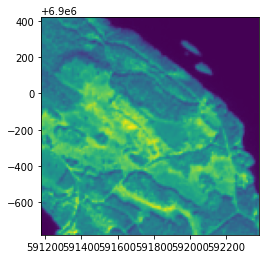

(120, 120)
03


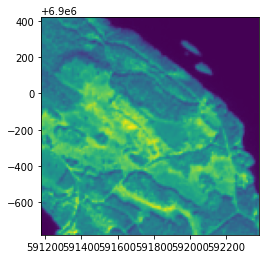

(120, 120)
04


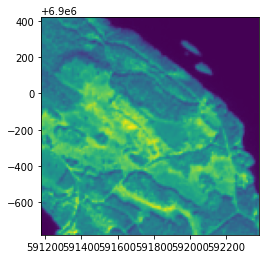

(120, 120)


In [132]:
# EXPLORATION

ITEM = "S2B_MSIL2A_20180525T94030_76_83"
rgb = {}
for color, band in bands_dict.items():
    path = f"{DATA_DIR}/bigearthnet-s2-data/{CLASSES[0]}/bigearthnet_v1_labels_{ITEM}/{ITEM}_B{band}.tif"
    array = rasterio.open(path)
    rgb[color] = array
    print(band)
    show(dataset)
    print(dataset.shape)

In [155]:
def create_rgb_image(rgb_arrays: dict):
    """Creates and rescales RGB image."""
    colors = [rgb_arrays["RED"], rgb_arrays["GREEN"], rgb_arrays["BLUE"]]
    image = [np.array(c.read(1)) for c in colors]

    image = np.stack(image, axis=2)
    image = image / _OPTICAL_MAX_VALUE * 255.0
    image = np.clip(image, 0, 255).astype(np.uint8)
    return image

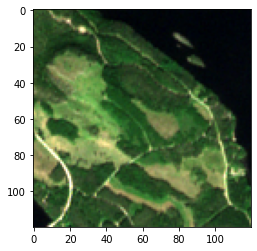

In [156]:
rgb_image = create_rgb_image(rgb)
pyplot.imshow(rgb_image)

In [103]:
for band in BANDS:
    path = f"{DATA_DIR}/bigearthnet-s2-data/{CLASSES[0]}/bigearthnet_v1_labels_{ITEM}/{ITEM}_B{band}.tif"
    image_content = tf.io.read_file(path)
    uint8_tensor = decode_tiff(image_content)

    print(band, uint8_tensor.get_shape())

02 (120, 120, 4)
03 (120, 120, 4)
04 (120, 120, 4)


In [8]:
# Create dataset from all satelite photos

### FILTER BANDS ###
all_images = []
for band in BANDS:
    all_images.append(glob.glob(f"{DATA_DIR}/bigearthnet-s2-data/**/**/*_B{band}.tif"))


all_images = list(itertools.chain(*all_images))
print(len(all_images))

4886


In [9]:
# Split Dataset

train, validation = train_test_split(
    all_images,
    test_size=0.05,
    random_state=random.randint(0, 1000),
    shuffle=True
)

validation, pred = train_test_split(
    validation,
    test_size=0.01,
    random_state=random.randint(0, 1000),
    shuffle=True
)

print(len(train))
print(len(validation))
print(len(pred))

4641
242
3


In [10]:
def create_dataframe(paths: List) -> pd.DataFrame:
    dataframe = pd.DataFrame(paths)
    dataframe.loc[:, "label"] = None
    dataframe.columns = ["image_path", "label"]
    for i, row in dataframe.iterrows():
        label = row[0].split("/")[7]
        dataframe.at[i, "label"] = label
    return dataframe
        
train_data_frame = create_dataframe(train)
validation_data_frame = create_dataframe(validation)

train_data_frame.loc[:,]


image_path             label
0     /Users/anders/skunk/footprint/satelite/bigeart...  not_water_bodies
1     /Users/anders/skunk/footprint/satelite/bigeart...  not_water_bodies
2     /Users/anders/skunk/footprint/satelite/bigeart...      water_bodies
3     /Users/anders/skunk/footprint/satelite/bigeart...  not_water_bodies
4     /Users/anders/skunk/footprint/satelite/bigeart...  not_water_bodies
...                                                 ...               ...
4636  /Users/anders/skunk/footprint/satelite/bigeart...  not_water_bodies
4637  /Users/anders/skunk/footprint/satelite/bigeart...  not_water_bodies
4638  /Users/anders/skunk/footprint/satelite/bigeart...  not_water_bodies
4639  /Users/anders/skunk/footprint/satelite/bigeart...      water_bodies
4640  /Users/anders/skunk/footprint/satelite/bigeart...  not_water_bodies

[4641 rows x 2 columns]

In [11]:
validation_data_frame.loc[:,]

image_path             label
0    /Users/anders/skunk/footprint/satelite/bigeart...      water_bodies
1    /Users/anders/skunk/footprint/satelite/bigeart...  not_water_bodies
2    /Users/anders/skunk/footprint/satelite/bigeart...  not_water_bodies
3    /Users/anders/skunk/footprint/satelite/bigeart...  not_water_bodies
4    /Users/anders/skunk/footprint/satelite/bigeart...  not_water_bodies
..                                                 ...               ...
237  /Users/anders/skunk/footprint/satelite/bigeart...      water_bodies
238  /Users/anders/skunk/footprint/satelite/bigeart...  not_water_bodies
239  /Users/anders/skunk/footprint/satelite/bigeart...  not_water_bodies
240  /Users/anders/skunk/footprint/satelite/bigeart...      water_bodies
241  /Users/anders/skunk/footprint/satelite/bigeart...  not_water_bodies

[242 rows x 2 columns]

In [12]:
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    rotation_range=360,
    zoom_range=0.5,
    fill_mode="reflect"
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_data_frame,
    x_col="image_path",
    y_col="label",
    color_mode="rgba",
    class_mode="binary",
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH), 
    batch_size=32
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_data_frame,
    x_col="image_path",
    y_col="label",
    color_mode="rgba",
    class_mode="binary",
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH), 
    batch_size=32
)

Found 4641 validated image filenames belonging to 2 classes.
Found 242 validated image filenames belonging to 2 classes.


In [13]:
# Model

model = tf.keras.Sequential([
    # CONV
    tf.keras.layers.Conv2D(
        512, 
        (3,3), 
        activation='relu', 
        input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NCHANNELS)
    ),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # DENSE
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    # OUTPUT
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 118, 118, 512)     18944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 59, 512)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 57, 128)       589952    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 32)        1

In [16]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)

145
7


In [17]:
history = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=10
)

Epoch 1/10
145/145 [==============================] - 367s 3s/step - loss: 0.6581 - accuracy: 0.6486 - val_loss: 0.6382 - val_accuracy: 0.6429
Epoch 2/10
145/145 [==============================] - 358s 2s/step - loss: 0.6328 - accuracy: 0.6656 - val_loss: 0.5936 - val_accuracy: 0.7321
Epoch 3/10
145/145 [==============================] - 346s 2s/step - loss: 0.6084 - accuracy: 0.6858 - val_loss: 0.6081 - val_accuracy: 0.7232
Epoch 4/10
145/145 [==============================] - 328s 2s/step - loss: 0.6164 - accuracy: 0.6734 - val_loss: 0.5924 - val_accuracy: 0.7054
Epoch 5/10
145/145 [==============================] - 329s 2s/step - loss: 0.6076 - accuracy: 0.6941 - val_loss: 0.5963 - val_accuracy: 0.7054
Epoch 6/10
145/145 [==============================] - 326s 2s/step - loss: 0.6079 - accuracy: 0.6908 - val_loss: 0.6006 - val_accuracy: 0.7054
Epoch 7/10
145/145 [==============================] - 322s 2s/step - loss: 0.6114 - accuracy: 0.6997 - val_loss: 0.5938 - val_accuracy: 0.7054

In [ ]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")

plt.title('Training and validation loss')

In [ ]:
import numpy as np
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
#cat_img_files = [os.path.join(path, f) for f in all_images]
#dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]

img_path = random.choice(all_images)
img = load_img(img_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT), color_mode="rgba")  # this is a PIL image

print(img)
img.show()
x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
print(x.shape)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)
print(x.shape)
# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    print(f"n features: {n_features}")
    
    size = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
        x  = feature_map[0, :, :, i]
        x -= x.mean()
        x /= x.std ()
        x *=  64
        x += 128
        x  = np.clip(x, 0, 255).astype('uint8')
        display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, cmap='viridis' ) 

In [ ]:
predictions = model.predict(pred_ds)
for path in pred:
    for e in predictions:
        p = "water body" if e[0] > 0 else "not water body"
        print(path.split("/")[7], p)
    